In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime WARNINGS, muestra solo errores

In [29]:
# Define latent dimension and input shape
latent_dim = 250
input_shape = (32, 32, 3)

In [30]:
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # TODO: Add a Conv2D layer with 16 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2D(
        strides = 1,
        filters = 32, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(inputs)
    
    x = MaxPooling2D((2,2), padding='same')(x)

    # TODO: Add a Conv2D layer with 8 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2D(
        strides = 1,
        filters = 16, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(x)
    
    x = MaxPooling2D((2,2), padding='same')(x)

    
    x = Conv2D(
        strides = 1,
        filters = 8, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(x)
    
    x = MaxPooling2D((2,2), padding='same')(x)


    # TODO: Save the shape before flattening for use in the decoder (e.g., shape_before_flattening = ?)
    shape_before_flattening = x.shape

    # TODO: Flatten the output
    x = Flatten()(x)

    # TODO: Add a Dense layer to produce the latent vector of dimension latent_dim
    # (assign the output of this Dense layer to a variable named "latent")
    latent = Dense(units= latent_dim, activation= 'relu')(x)

    encoder = Model(inputs, latent, name="encoder")
    return encoder, shape_before_flattening


In [31]:
def build_decoder(latent_dim, shape_before_flattening):
    latent_inputs = Input(shape=(latent_dim,))

    # TODO: Add a Dense layer to expand the latent vector back to the size of the flattened feature map
    x = Dense(
        np.prod(
            shape_before_flattening[1:]
        ),
        activation='relu'
    )(latent_inputs)

    # TODO: Reshape the expanded vector back to the shape before flattening
    x = Reshape(shape_before_flattening[1:])(x)

    # TODO: Add a Conv2DTranspose layer with 8 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2DTranspose(
        filters= 8,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2DTranspose(
        filters= 16,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)

    # TODO: Add a Conv2DTranspose layer with 16 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2DTranspose(
        filters= 32,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)

    # TODO: Add a final Conv2D layer with 3 filters, kernel size (1,1), activation 'sigmoid', and padding 'same'
    # (assign the output of this layer to a variable named "outputs")
    outputs = Conv2DTranspose(
        filters= 3,
        kernel_size=(3,3),
        activation='sigmoid',
        padding='same'
    )(x)

    decoder = Model(latent_inputs, outputs, name="decoder")
    return decoder

In [32]:
# Build encoder and decoder
encoder, shape_before_flattening = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, shape_before_flattening)

# Create the full autoencoder by connecting encoder and decoder
input_img = Input(shape=input_shape)
latent_repr = encoder(input_img)
reconstructed_img = decoder(latent_repr)
autoencoder = Model(input_img, reconstructed_img, name="autoencoder")

# TODO: Compile the autoencoder with an optimizer (e.g., Adam) and a loss function (e.g., 'binary_crossentropy')
autoencoder.compile(optimizer=Adam(), loss='mse')

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 250)            │        38,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │        39,387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,317 (305.93 KB)

 Trainable params: 78,317 (305.93 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:

# Load CIFAR-10 data and normalize pixel values to [0, 1]
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

In [34]:
# training
autoencoder.fit(
    x_train, x_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose = 1
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0477 - val_loss: 0.0236
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0221 - val_loss: 0.0211
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0195 - val_loss: 0.0211
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0183 - val_loss: 0.0178
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0168 - val_loss: 0.0220
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0151 - val_loss: 0.0157
Epoch 12/100
196/196 ━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


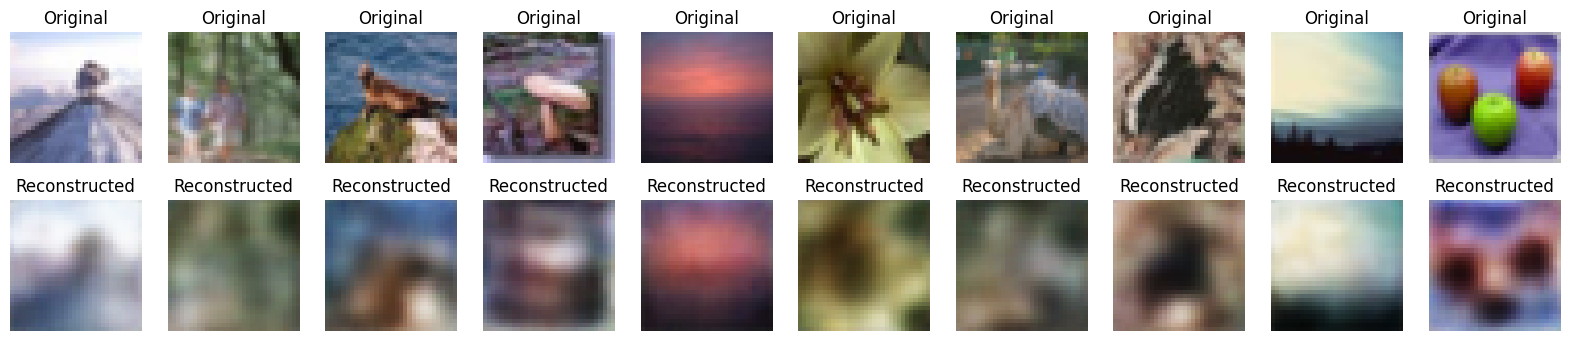

In [35]:
# Reconstruct images from the test set
decoded_imgs = autoencoder.predict(x_test)

# Visualize original and reconstructed images side by side
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [36]:
decoded_imgs.shape

(10000, 32, 32, 3)

In [37]:
x_test.shape

(10000, 32, 32, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

def extract_logits(images, batch_size=500):
    """
    Extrae los logits de las imágenes usando ResNet152V2.
    
    Parámetros:
    - batch_size: Tamaño de lote para evitar desbordamiento de memoria, para evitar que la GPU pare el proceso

    Retorna:
    - logits: Array de logits extraídos de ResNet152V2.
    """
    # if len(images.shape) != 4 or images.shape[-1] != 3:
    #     raise ValueError("Las imágenes deben tener la forma (N, H, W, 3)")

    resized_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i : i + batch_size]
        batch_resized = tf.image.resize(batch, (224, 224)).numpy()
        resized_images.append(batch_resized)

    images_resized = np.concatenate(resized_images, axis=0)
    
    base_model = ResNet152V2(include_top=False, input_shape=(224, 224, 3), pooling="avg")
    model = Model(inputs=base_model.input, outputs=base_model.output)

    images_resized = preprocess_input(images_resized)

    logits_list = []
    for i in range(0, len(images_resized), batch_size):
        batch = images_resized[i : i + batch_size]
        logits_batch = model.predict(batch)
        logits_list.append(logits_batch)

    logits = np.concatenate(logits_list, axis=0)
    return logits

In [42]:
real_logits = extract_logits(x_test)
generated_logits = extract_logits(decoded_imgs)

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 692ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
16/16 ━━━━━━━━

In [43]:
from scipy.spatial.distance import cosine

def cosine_distance(features1, features2):
    distances = [cosine(f1, f2) for f1, f2 in zip(features1, features2)]
    return np.mean(distances)

cosine_dist = cosine_distance(real_logits, generated_logits)
print(f'Distancia Coseno: {cosine_dist}')

Distancia Coseno: 0.019283084198832512
